In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from PIL import Image
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Cropping2D, ZeroPadding2D, Lambda
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import Input, Flatten, Dense, Reshape
import tensorflow_probability as tfp
from tensorflow_probability import layers as tfpl
from tensorflow_probability import distributions as tfd
from tensorflow.nn import leaky_relu
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
from sklearn.model_selection import train_test_split

x_val ,x_test ,y_val, y_test = train_test_split(x_test,y_test,random_state=42,test_size=0.5)


# Preprocess data
x_train = x_train.astype('float32') / 255.0
x_train = np.transpose(x_train, (0, 3, 1, 2))

x_test = x_test.astype('float32') / 255.0
x_test = np.transpose(x_test, (0, 3, 1, 2))

x_val = x_val.astype('float32') / 255.0
x_val = np.transpose(x_val,(0, 3, 1, 2))

from sklearn.model_selection import train_test_split

# Define model architecture
LATENT_DIM = 256
BASE_DEPTH = 8
KL_WEIGHT = 1e-5
prior = tfd.Independent(tfd.Normal(loc=tf.zeros(LATENT_DIM), scale = 0.1), reinterpreted_batch_ndims = 1)


IMAGE_SHAPE = (3,32,32)
images = Input(shape = (3,32, 32))
redshifts = Input(shape = 1,)
conv1 = Conv2D(BASE_DEPTH, 3, strides = 2, activation = leaky_relu,
            padding = 'same', data_format = 'channels_first')(images)
conv2 = Conv2D(BASE_DEPTH, 3, strides = 2, activation = leaky_relu,
            padding = 'same', data_format = 'channels_first')(conv1)
flatten = Flatten()(conv2)
dense1 = Dense(1024, activation = None)(flatten)
dense2 = tf.keras.layers.Dense(32, activation = "relu")(redshifts)
dense3 = tf.keras.layers.Dense(32, activation = "relu")(dense2)
concat = tf.keras.layers.Concatenate()([dense1, dense3])
dense4 = Dense(tfpl.MultivariateNormalTriL.params_size(LATENT_DIM), activation = None)(concat)
z = tfpl.MultivariateNormalTriL(LATENT_DIM,
            activity_regularizer=tfpl.KLDivergenceRegularizer(prior, weight = KL_WEIGHT))(dense4)
encoder = Model([images, redshifts], z)
zc = tf.keras.layers.Concatenate()([z, redshifts])


In [2]:
prior = tfd.Independent(tfd.Normal(loc=tf.zeros(LATENT_DIM), scale = 0.1), reinterpreted_batch_ndims = 1)

images = Input(shape = IMAGE_SHAPE)
redshifts = Input(shape = 1,)
conv1 = Conv2D(BASE_DEPTH, 3, strides = 2, activation = leaky_relu,
            padding = 'same', data_format = 'channels_first')(images)
conv2 = Conv2D(BASE_DEPTH, 3, strides = 2, activation = leaky_relu,
            padding = 'same', data_format = 'channels_first')(conv1)
flatten = Flatten()(conv2)
dense1 = Dense(1024, activation = None)(flatten)
dense2 = tf.keras.layers.Dense(32, activation = "relu")(redshifts)
dense3 = tf.keras.layers.Dense(32, activation = "relu")(dense2)
concat = tf.keras.layers.Concatenate()([dense1, dense3])
dense4 = Dense(tfpl.MultivariateNormalTriL.params_size(LATENT_DIM), activation = None)(concat)
z = tfpl.MultivariateNormalTriL(LATENT_DIM,
            activity_regularizer=tfpl.KLDivergenceRegularizer(prior, weight = KL_WEIGHT))(dense4)
encoder = Model([images, redshifts], z)

zc = tf.keras.layers.Concatenate()([z, redshifts])

In [3]:
dense5 = Dense(8 * LATENT_DIM * 32 * 32, activation = None) #adjust this to modify image dimension without cropping
reshape = Reshape((8 * LATENT_DIM, 32, 32))
conv3 = Conv2DTranspose(BASE_DEPTH, 3, strides = 2, activation = leaky_relu,
                    padding = 'same', data_format = 'channels_first')
conv4 = Conv2DTranspose(BASE_DEPTH, 3, strides = 2, activation = leaky_relu,
                    padding = 'same', data_format = 'channels_first')
conv5 = Conv2DTranspose(BASE_DEPTH, 3, strides = 1, activation = leaky_relu, 
                    padding = 'same', data_format = 'channels_first')
conv6 = Conv2D(IMAGE_SHAPE[0], 3, strides = 1, activation = None, 
           padding = 'same', data_format = 'channels_first')
cropping = Cropping2D(cropping=((0, 96), (0, 96)), data_format = 'channels_first')
outputs = Reshape(IMAGE_SHAPE)

In [4]:
dense5_model = dense5(zc)
reshape_model = reshape(dense5_model)
conv3_model = conv3(reshape_model)
conv4_model = conv4(conv3_model)
conv5_model = conv5(conv4_model)
conv6_model = conv6(conv5_model)
cropping_model = cropping(conv6_model)
outputs_model = outputs(cropping_model)

In [5]:
latents = Input(shape = (LATENT_DIM + 1, ))
dense5_decoder = dense5(latents)
reshape_decoder = reshape(dense5_decoder)
conv3_decoder = conv3(reshape_decoder)
conv4_decoder = conv4(conv3_decoder)
conv5_decoder = conv5(conv4_decoder)
conv6_decoder = conv6(conv5_decoder)
cropping_decoder = cropping(conv6_decoder)
outputs_decoder = outputs(cropping_decoder)

In [6]:
model = Model(inputs = [images, redshifts], outputs = [outputs_model])


In [7]:
decoder = Model(latents, outputs_decoder)
model.compile(optimizer = 'adam', loss = 'mse')


In [10]:
history = model.fit(x = [x_train, y_train], y = x_train, epochs = 5, verbose = 1)


Epoch 1/5
1563/1563 [==============================] - 380s 49ms/step - loss: 0.0482
Epoch 2/5
1563/1563 [==============================] - 76s 49ms/step - loss: 0.0232
Epoch 3/5
1563/1563 [==============================] - 76s 49ms/step - loss: 0.0200
Epoch 4/5
1563/1563 [==============================] - 76s 49ms/step - loss: 0.0184
Epoch 5/5
1563/1563 [==============================] - 76s 49ms/step - loss: 0.0173


In [39]:
history = model.fit(x = [x_train, y_train], y = x_train, epochs = 200, verbose = 1)


Epoch 1/200
1563/1563 [==============================] - 76s 49ms/step - loss: 0.0134
Epoch 2/200
1563/1563 [==============================] - 76s 49ms/step - loss: 0.0134
Epoch 3/200
1563/1563 [==============================] - 77s 49ms/step - loss: 0.0133
Epoch 4/200
1563/1563 [==============================] - 77s 49ms/step - loss: 0.0133
Epoch 5/200
1563/1563 [==============================] - 76s 49ms/step - loss: 0.0132
Epoch 6/200
1563/1563 [==============================] - 76s 49ms/step - loss: 0.0132
Epoch 7/200
1563/1563 [==============================] - 76s 49ms/step - loss: 0.0132
Epoch 8/200
1563/1563 [==============================] - 77s 49ms/step - loss: 0.0131
Epoch 9/200
1563/1563 [==============================] - 76s 49ms/step - loss: 0.0131
Epoch 10/200
1563/1563 [==============================] - 76s 49ms/step - loss: 0.0131
Epoch 11/200
1563/1563 [==============================] - 76s 49ms/step - loss: 0.0131
Epoch 12/200
1563/1563 [============================

In [8]:
history = model.fit(x = [x_train, y_train], y = x_train, epochs = 50,  validation_data = ([x_val, y_val], x_val), verbose = 1)


Epoch 1/50
1563/1563 [==============================] - 490s 50ms/step - loss: 0.0484 - val_loss: 0.0270
Epoch 2/50
1563/1563 [==============================] - 78s 50ms/step - loss: 0.0228 - val_loss: 0.0210
Epoch 3/50
1563/1563 [==============================] - 78s 50ms/step - loss: 0.0194 - val_loss: 0.0186
Epoch 4/50
1563/1563 [==============================] - 78s 50ms/step - loss: 0.0177 - val_loss: 0.0173
Epoch 5/50
1563/1563 [==============================] - 78s 50ms/step - loss: 0.0169 - val_loss: 0.0166
Epoch 6/50
1563/1563 [==============================] - 78s 50ms/step - loss: 0.0163 - val_loss: 0.0161
Epoch 7/50
1563/1563 [==============================] - 78s 50ms/step - loss: 0.0157 - val_loss: 0.0156
Epoch 8/50
1563/1563 [==============================] - 78s 50ms/step - loss: 0.0154 - val_loss: 0.0156
Epoch 9/50
1563/1563 [==============================] - 78s 50ms/step - loss: 0.0151 - val_loss: 0.0151
Epoch 10/50
1563/1563 [==============================] - 78s 50

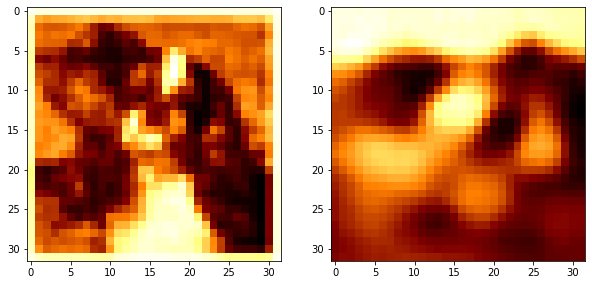

Redshift: 
[7]
Loss: 
0.0179226603358984


In [19]:
import matplotlib.pyplot as plt
index = 500
z = y_test[index]
str = np.asarray(encoder([np.array([x_test[index]]), np.array([y_test[index]])])[0])
str = np.concatenate((str, np.array(z)))
str = str.reshape(1, LATENT_DIM+1)
loss = model.evaluate([np.array([x_test[index]]), np.array([y_test[index]])], np.array([x_test[index]]), verbose = 0)
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 5))
axes[0].imshow(x_train[index][0], cmap = 'afmhot')
axes[1].imshow(decoder.predict([str])[0][0], cmap = 'afmhot')
plt.show()
print("Redshift: ")
print(z)
print("Loss: ")
print(loss)

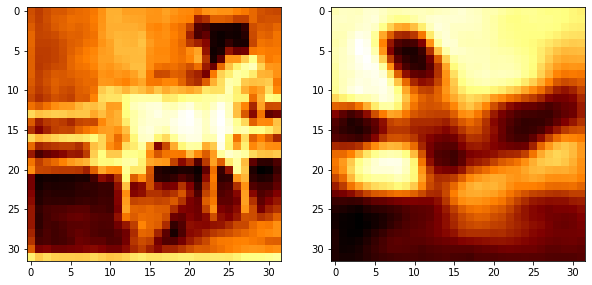

Redshift: 
[7]
Loss: 
0.01942175254225731


In [14]:
import matplotlib.pyplot as plt
index = 230
z = y_test[index]
str = np.asarray(encoder([np.array([x_test[index]]), np.array([y_test[index]])])[0])
str = np.concatenate((str, np.array(z)))
str = str.reshape(1, LATENT_DIM+1)
loss = model.evaluate([np.array([x_test[index]]), np.array([y_test[index]])], np.array([x_test[index]]), verbose = 0)
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 5))
axes[0].imshow(x_train[index][0], cmap = 'afmhot')
axes[1].imshow(decoder.predict([str])[0][0], cmap = 'afmhot')
plt.show()
print("Redshift: ")
print(z)
print("Loss: ")
print(loss)

In [27]:
x_test[index].ndim

3

In [15]:
y_test[105]

array([1], dtype=uint8)

In [17]:
np.asarray(encoder([np.array([x_test[index]]), np.array([y_test[index]])])[0])

array([-0.06280217,  0.02258706,  0.30130094, -0.25928488, -0.07156122,
        0.15161216,  0.08731753, -0.15911236, -0.19692829,  0.3362445 ,
        0.07683092, -0.03270894,  0.02113801,  0.04687989, -0.06520121,
       -0.05022586,  0.16820058,  0.29905534, -0.22905606,  0.20098218,
       -0.13792922,  0.43644467, -0.04089607, -0.18495731,  0.05066067,
       -0.00063094, -0.10923873,  0.09204622,  0.02749453,  0.15541822,
        0.03024387, -0.07321063, -0.16098498, -0.20652384, -0.01656354,
       -0.17163   , -0.19200893,  0.09707733, -0.01923371,  0.06250761,
        0.2030282 ,  0.0403696 , -0.14873165,  0.20794669, -0.11635599,
        0.03255361, -0.1219746 ,  0.09075877,  0.0049441 , -0.00279888,
        0.02481305,  0.22014613,  0.01612223, -0.0918682 , -0.19965376,
        0.14125991,  0.02058074, -0.07040107,  0.1409423 , -0.15759905,
       -0.08486951, -0.21759406, -0.14547312, -0.13258883,  0.16672781,
        0.02312098, -0.2514549 ,  0.20414168,  0.1829612 , -0.15